In [1]:
import os
import sys

sys.path.append('..')

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

from src import FacialEmotionDataLoader
from src import FacialEmotionCNN

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


### Load Data

In [4]:
dataset_path = '../data'
batch_size = 32

data_loader = FacialEmotionDataLoader(dataset_path=dataset_path, model_type='cnn', batch_size=batch_size)
train_loader, test_loader, class_names = data_loader.get_data_loaders()

In [5]:
model = FacialEmotionCNN(num_classes=len(class_names)).to(device)

### Training Setup

In [6]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

num_epochs = 50

train_loss_history = list()
test_loss_history = list()

best_test_loss = float('inf')
patience = 5
early_stop_counter = 0
early_stop_threshold = 0.005

In [7]:
os.makedirs('../output', exist_ok=True)

### Training Loop

In [8]:
print('Starting training...\n')

for epoch in range(num_epochs):
    model.train()
    running_train_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_train_loss += loss.item()

    avg_train_loss = running_train_loss / len(train_loader)
    train_loss_history.append(avg_train_loss)

    model.eval()
    running_test_loss = 0.0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_test_loss += loss.item()

    avg_test_loss = running_test_loss / len(test_loader)
    test_loss_history.append(avg_test_loss)

    scheduler.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Test Loss: {avg_test_loss:.4f}')

    loss_improvement = best_test_loss - avg_test_loss

    if loss_improvement >= early_stop_threshold:
        best_test_loss = avg_test_loss
        early_stop_counter = 0
        torch.save(model.state_dict(), '../output/cnn_best_model.pth')
        print('Model improved. Saving checkpoint...')
    else:
        early_stop_counter += 1
        print(f'No significant improvement (Δ {loss_improvement:.6f}).')
        if early_stop_counter >= patience:
            print('Early stopping triggered.')
            break

print('\nTraining complete.')

Starting training...

Epoch [1/50], Train Loss: 1.4431, Test Loss: 1.4956
Model improved. Saving checkpoint...
Epoch [2/50], Train Loss: 1.1794, Test Loss: 1.2001
Model improved. Saving checkpoint...
Epoch [3/50], Train Loss: 1.0249, Test Loss: 1.0730
Model improved. Saving checkpoint...
Epoch [4/50], Train Loss: 0.9495, Test Loss: 0.8929
Model improved. Saving checkpoint...
Epoch [5/50], Train Loss: 0.8896, Test Loss: 0.9496
No significant improvement (Δ -0.056694).
Epoch [6/50], Train Loss: 0.8124, Test Loss: 0.7785
Model improved. Saving checkpoint...
Epoch [7/50], Train Loss: 0.7795, Test Loss: 0.7817
No significant improvement (Δ -0.003152).
Epoch [8/50], Train Loss: 0.7478, Test Loss: 0.8035
No significant improvement (Δ -0.025004).
Epoch [9/50], Train Loss: 0.7195, Test Loss: 0.8231
No significant improvement (Δ -0.044612).
Epoch [10/50], Train Loss: 0.7126, Test Loss: 0.6995
Model improved. Saving checkpoint...
Epoch [11/50], Train Loss: 0.6509, Test Loss: 0.6630
Model improved

### Evaluation

In [9]:
model.eval()
all_preds = list()
all_labels = list()

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds, average='macro')
recall = recall_score(all_labels, all_preds, average='macro')
f1 = f1_score(all_labels, all_preds, average='macro')

print(f'Test Accuracy: {accuracy * 100:.2f}%')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

print('\nClassification Report:')
print(classification_report(all_labels, all_preds, target_names=class_names))

Test Accuracy: 75.33%
Precision: 0.7767
Recall: 0.7247
F1 Score: 0.7432

Classification Report:
              precision    recall  f1-score   support

       Angry       0.79      0.62      0.70       279
       Happy       0.88      0.92      0.90       750
     Neutral       0.63      0.80      0.70       750
         Sad       0.75      0.64      0.69       824
    Surprise       0.83      0.65      0.73       247

    accuracy                           0.75      2850
   macro avg       0.78      0.72      0.74      2850
weighted avg       0.76      0.75      0.75      2850



### Plot Training Loss

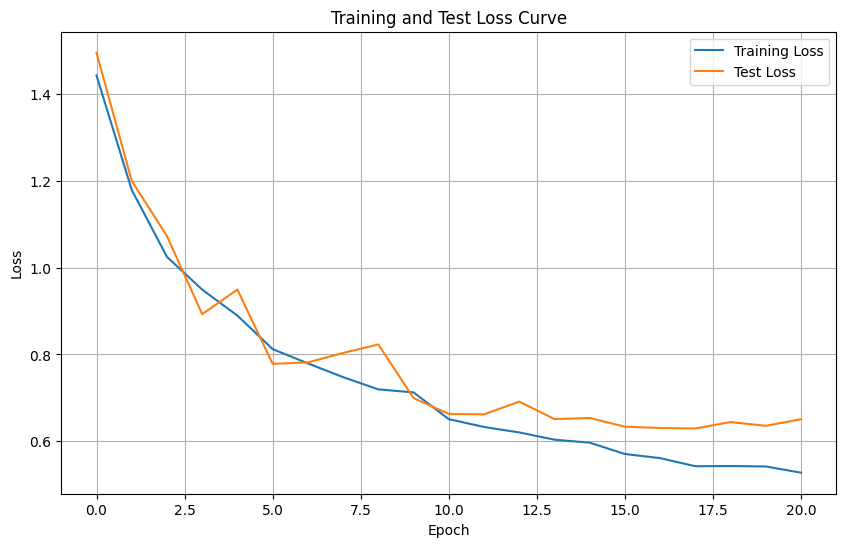

In [10]:
plt.figure(figsize=(10, 6))
plt.plot(train_loss_history, label='Training Loss')
plt.plot(test_loss_history, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss Curve')
plt.legend()
plt.grid()
plt.show()

### Plot Confusion Matrix

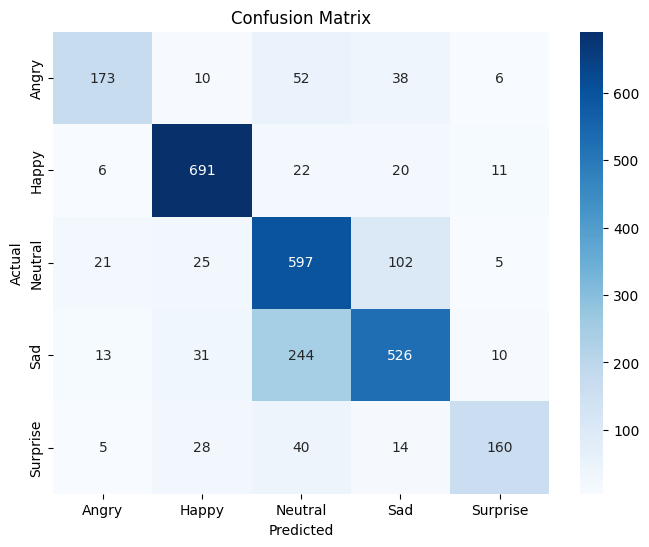

In [11]:
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

---